In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
%config Completer.use_jedi = False

In [2]:
import sys
from pathlib import Path
(Path.cwd().parent)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast')

In [3]:
str(Path.cwd().parent.parent)

'c:\\Users\\jaesc2\\GitHub'

## Librerias

In [3]:
## ForecasterAutoregMultiSeries
# ==============================================================================
from typing import Union, Dict, List, Tuple, Any, Optional
import warnings
import logging
import sys
import inspect
import numpy as np
import pandas as pd
import sklearn
import sklearn.pipeline
from sklearn.base import clone
from copy import copy

import skforecast
from skforecast.ForecasterBase import ForecasterBase
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import transform_series
from skforecast.utils import transform_dataframe

## Create_train_X_y

In [7]:
class dummy_forecaster():
    
    def __init__(
        self,
        regressor,
        lags: Union[int, np.ndarray, list],
        transformer_series: Optional[object]=None,
        transformer_exog: Optional[object]=None,
        series_weights: Optional[dict]=None
    ) -> None:
        
        self.regressor            = regressor
        self.transformer_series   = transformer_series
        self.transformer_exog     = transformer_exog
        self.series_weights       = series_weights
        self.index_type           = None
        self.index_freq           = None
        self.index_values         = None
        self.training_range       = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.series_levels        = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.out_sample_residuals = None
        self.fitted               = False
        self.creation_date        = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.fit_date             = None
        self.skforcast_version    = skforecast.__version__
        self.python_version       = sys.version.split(" ")[0]
        
        if isinstance(lags, int) and lags < 1:
            raise ValueError('Minimum value of lags allowed is 1.')

        if isinstance(lags, (list, np.ndarray)):
            for lag in lags:
                if not isinstance(lag, (int, np.int64, np.int32)):
                    raise TypeError('All values in `lags` must be int.')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise ValueError('Minimum value of lags allowed is 1.')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise TypeError(
                '`lags` argument must be int, 1d numpy ndarray, range or list. '
                f"Got {type(lags)}"
            )

        if series_weights is not None:
            if 'sample_weight' not in inspect.getfullargspec(self.regressor.fit)[0]:
                warnings.warm(
                    f"""
                    Argument `series_weights` is ignored since regressor {self.regressor}
                    does not accept `sample_weight` in its `fit` method.
                    """
                )
                self.series_weights = None
            
        self.max_lag = max(self.lags)
        self.window_size = self.max_lag


    def __repr__(
        self
    ) -> str:
        """
        Information displayed when a ForecasterAutoregMultiSeries object is printed.
        """

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            name_pipe_steps = tuple(name + "__" for name in self.regressor.named_steps.keys())
            params = {key : value for key, value in self.regressor.get_params().items() \
                     if key.startswith(name_pipe_steps)}
        else:
            params = self.regressor.get_params()

        info = (
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"{str(type(self)).split('.')[1]} \n"
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"Regressor: {self.regressor} \n"
            f"Lags: {self.lags} \n"
            f"Transformer for series: {self.transformer_series} \n"
            f"Transformer for exog: {self.transformer_exog} \n"
            f"Window size: {self.window_size} \n"
            f"Series levels (names): {self.series_levels} \n"
            f"Series weights: {self.series_weights} \n"
            f"Included exogenous: {self.included_exog} \n"
            f"Type of exogenous variable: {self.exog_type} \n"
            f"Exogenous variables names: {self.exog_col_names} \n"
            f"Training range: {self.training_range.to_list() if self.fitted else None} \n"
            f"Training index type: {str(self.index_type).split('.')[-1][:-2] if self.fitted else None} \n"
            f"Training index frequency: {self.index_freq if self.fitted else None} \n"
            f"Regressor parameters: {params} \n"
            f"Creation date: {self.creation_date} \n"
            f"Last fit date: {self.fit_date} \n"
            f"Skforecast version: {self.skforcast_version} \n"
            f"Python version: {self.python_version} \n"
        )

        return info


In [8]:
forecaster = dummy_forecaster(
                 regressor = 'dummy',
                 lags = 5
             )

In [9]:
forecaster.lags

array([1, 2, 3, 4, 5])

In [10]:
forecaster.max_lag

5

In [11]:
def _create_lags(
    self, 
    y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
        
    n_splits = len(y) - self.max_lag
    if n_splits <= 0:
        raise ValueError(
            f'The maximum lag ({self.max_lag}) must be less than the length '
            f'of the series ({len(y)}).'
        )
    
    X_data = np.full(shape=(n_splits, len(self.lags)), fill_value=np.nan, dtype=float)

    for i, lag in enumerate(self.lags):
        X_data[:, i] = y[self.max_lag - lag: -lag]

    y_data = y[self.max_lag:]
        
    return X_data, y_data

In [16]:
_create_lags(forecaster, np.array(list(range(10))))

(array([[4., 3., 2., 1., 0.],
        [5., 4., 3., 2., 1.],
        [6., 5., 4., 3., 2.],
        [7., 6., 5., 4., 3.],
        [8., 7., 6., 5., 4.]]),
 array([5, 6, 7, 8, 9]))

In [13]:
def create_train_X_y(
    self,
    series: pd.DataFrame,
    exog: Optional[Union[pd.Series, pd.DataFrame]]=None
) -> Tuple[pd.DataFrame, pd.Series]:

    if not isinstance(series, pd.DataFrame):
        raise TypeError(f'`series` must be a pandas DataFrame. Got {type(series)}.')

    series_levels = list(series.columns)

    if self.transformer_series is None:
        dict_transformers = {level: None for level in series_levels}
        self.transformer_series = dict_transformers
    elif not isinstance(self.transformer_series, dict):
        dict_transformers = {level: clone(self.transformer_series) 
                                for level in series_levels}
        self.transformer_series = dict_transformers
    else:
        if list(self.transformer_series.keys()) != series_levels:
            raise ValueError(
                (f'When `transformer_series` parameter is a `dict`, its keys '
                    f'must be the same as `series_levels` : {series_levels}.')
            )
    
    X_train_col_names = [f"{level}_lag_{lag}" for level in series_levels for lag in self.lags]

    for i, serie in enumerate(series.columns):

        y = series[serie]
        check_y(y=y)
        y = transform_series(
                series            = y,
                transformer       = self.transformer_series[serie],
                fit               = True,
                inverse_transform = False
            )
        y_values, y_index = preprocess_y(y=y)
        X_train_values, y_train_values = self._create_lags(y=y_values)

        if i == 0:
            X_train = X_train_values
            y_train = y_train_values
        else:
            X_train = np.hstack((X_train, X_train_values))
            y_train = np.append(y_train, y_train_values)

    if exog is not None:
        if len(exog) != len(series):
            raise ValueError(
                f'`exog` must have same number of samples as `series`. '
                f'length `exog`: ({len(exog)}), length `series`: ({len(series)})'
            )
        check_exog(exog=exog)
        if isinstance(exog, pd.Series):
            exog = transform_series(
                        series            = exog,
                        transformer       = self.transformer_exog,
                        fit               = True,
                        inverse_transform = False
                    )
        else:
            exog = transform_dataframe(
                        df                = exog,
                        transformer       = self.transformer_exog,
                        fit               = True,
                        inverse_transform = False
                    )
        exog_values, exog_index = preprocess_exog(exog=exog)
        if not (exog_index[:len(y_index)] == y_index).all():
            raise ValueError(
                ('Different index for `series` and `exog`. They must be equal '
                    'to ensure the correct alignment of values.')      
            )
        col_names_exog = exog.columns if isinstance(exog, pd.DataFrame) else [exog.name]
        X_train_col_names.extend(col_names_exog)

        # The first `self.max_lag` positions have to be removed from exog
        # since they are not in X_train. Then exog is cloned as many times
        # as series.
        if exog_values.ndim == 1:
            X_train = np.column_stack((
                        X_train,
                        np.tile(exog_values[self.max_lag:, ], series.shape[1])
                        )) 

        else:
            X_train = np.column_stack((
                        X_train,
                        np.tile(exog_values[self.max_lag:, ], [series.shape[1], 1])
                        ))

    X_levels = pd.Series(X_levels)
    X_levels = pd.get_dummies(X_levels, dtype=float)
    X_train_col_names.extend(X_levels.columns)
    X_train = np.column_stack((X_train, X_levels.values))

    X_train = pd.DataFrame(
                data    = X_train,
                columns = X_train_col_names
            )

    y_train = pd.Series(
                data  = y_train,
                name  = 'y'
            )
    
    self.X_train_col_names = X_train_col_names

    return X_train, y_train, y_index

In [35]:
series_1 = pd.DataFrame({'1': pd.Series(np.arange(5)),  
                         '2': pd.Series(np.arange(5))
                        })

series_2 = pd.DataFrame({'1': pd.Series(np.arange(100, 105)),  
                         '2': pd.Series(np.arange(100, 105))
                        })

X_train = np.hstack((series_1.values, series_2.values))
X_train

array([[  0,   0, 100, 100],
       [  1,   1, 101, 101],
       [  2,   2, 102, 102],
       [  3,   3, 103, 103],
       [  4,   4, 104, 104]])

In [38]:
lags = np.array([1,2,3])
levels = ['l1', 'l2']

[f"{level}_lag_{lag}" for level in levels for lag in lags]

['l1_lag_1', 'l1_lag_2', 'l1_lag_3', 'l2_lag_1', 'l2_lag_2', 'l2_lag_3']

## Init

In [8]:
class ForecasterAutoregMultiVariate(ForecasterBase):
        
    def __init__(
        self,
        regressor: dict[str, object],
        lags: dict[str, Union[int, np.ndarray, list]],
        transformer_series: Optional[Union[object, dict[str, object]]]=None,
        transformer_exog: Optional[Union[object, dict[str, object]]]=None,
        series_weights: Optional[dict[str, float]]=None,
        weight_func: Optional[Union[callable, dict[str, callable]]]=None
    ) -> None:
        
        self.regressor               = regressor
        self.transformer_series      = transformer_series
        self.transformer_exog        = transformer_exog
        self.series_weights          = series_weights
        self.weight_func             = weight_func
        self.source_code_weight_func = None
        self.index_type              = None
        self.index_freq              = None
        self.index_values            = None
        self.training_range          = None
        self.last_window             = None
        self.included_exog           = False
        self.exog_type               = None
        self.exog_col_names          = None
        self.series_levels           = None
        self.X_train_col_names       = None
        self.in_sample_residuals     = None
        self.out_sample_residuals    = None
        self.fitted                  = False
        self.creation_date           = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.fit_date                = None
        self.skforcast_version       = skforecast.__version__
        self.python_version          = sys.version.split(" ")[0]
        
        if not isinstance(self.regressor, dict):
            raise TypeError(
                ('The `regressor` argument must be a `dict` containing the levels of '
                 'the forecaster (column names of the series) as keys and the '
                 'corresponding regressor for each level. {level (str) : regressor}.')
            )

        for key in self.regressor:
            if not isinstance(key, str):
                raise TypeError(
                    f"All regressor dict keys must be a string.\n"
                    f"    Key {key} is a {type(key)}"
                )

        # Next crear lags dict, si es un dict comprobar que coinciden las keys

        if isinstance(lags, int) and lags < 1:
            raise ValueError('Minimum value of lags allowed is 1.')

        if isinstance(lags, (list, np.ndarray)):
            for lag in lags:
                if not isinstance(lag, (int, np.int64, np.int32)):
                    raise TypeError('All values in `lags` must be int.')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise ValueError('Minimum value of lags allowed is 1.')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise TypeError(
                '`lags` argument must be int, 1d numpy ndarray, range or list. '
                f"Got {type(lags)}"
            )

        if series_weights is not None:
            if 'sample_weight' not in inspect.getfullargspec(self.regressor.fit)[0]:
                warnings.warm(
                    f"""
                    Argument `series_weights` is ignored since regressor {self.regressor}
                    does not accept `sample_weight` in its `fit` method.
                    """
                )
                self.series_weights = None
            
        self.max_lag = max(self.lags)
        self.window_size = self.max_lag


    def __repr__(
        self
    ) -> str:
        """
        Information displayed when a ForecasterAutoregMultiSeries object is printed.
        """

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            name_pipe_steps = tuple(name + "__" for name in self.regressor.named_steps.keys())
            params = {key : value for key, value in self.regressor.get_params().items() \
                     if key.startswith(name_pipe_steps)}
        else:
            params = self.regressor.get_params()

        info = (
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"{str(type(self)).split('.')[1]} \n"
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"Regressor: {self.regressor} \n"
            f"Lags: {self.lags} \n"
            f"Transformer for series: {self.transformer_series} \n"
            f"Transformer for exog: {self.transformer_exog} \n"
            f"Window size: {self.window_size} \n"
            f"Series levels (names): {self.series_levels} \n"
            f"Series weights: {self.series_weights} \n"
            f"Included exogenous: {self.included_exog} \n"
            f"Type of exogenous variable: {self.exog_type} \n"
            f"Exogenous variables names: {self.exog_col_names} \n"
            f"Training range: {self.training_range.to_list() if self.fitted else None} \n"
            f"Training index type: {str(self.index_type).split('.')[-1][:-2] if self.fitted else None} \n"
            f"Training index frequency: {self.index_freq if self.fitted else None} \n"
            f"Regressor parameters: {params} \n"
            f"Creation date: {self.creation_date} \n"
            f"Last fit date: {self.fit_date} \n"
            f"Skforecast version: {self.skforcast_version} \n"
            f"Python version: {self.python_version} \n"
        )

        return info

In [9]:
for key in {'1':1, 2:2}.keys():
    

{1: 1}

In [27]:
for key in {'1':1, 2:2}.keys():
    if not isinstance(key, str):
        raise TypeError(
            f"All regressor dict keys must be a string.\n"
            f"    Key {key} is a {type(key)}"
        )

TypeError: `lags` argument must be int, 1d numpy ndarray, range or list.
Got : [<class 'str'>, <class 'int'>]

In [26]:
[type(key) for key in {'1':1, 2:2}.keys()]

[str, int]

In [37]:
y = np.arange(10).reshape(-1, 1)
x = np.arange(10).reshape(-1, 1)
weights = [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]

In [36]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X=x, y=y, sample_weight=weights)
model.predict(y)

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_6968\380885746.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X=x, y=y, sample_weight=weights)
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\sklearn\ensemble\_forest.py:667: RuntimeWarning: invalid value encountered in add
  out[0] += prediction


array([-inf, -inf, -inf,  nan,  nan,  nan,  nan,  inf,  inf,  inf])

In [38]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X=x, y=y, sample_weight=weights)
model.predict(y)

ValueError: Negative values in data passed to `sample_weight`

In [41]:
weights = [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]

np.any(np.array(weights) < 0)

False

## ForecasterAutoregDirect

In [55]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [56]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
# fig, ax=plt.subplots(figsize=(9, 4))
# data_train.plot(ax=ax, label='train')
# data_test.plot(ax=ax, label='test')
# ax.legend();

In [57]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(),
                 steps     = 5,
                 lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregDirect 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Included weights function: False 
Window size: 15 
Maximum steps predicted: 5 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-11-03 13:47:31 
Last fit date: 2022-11-03 13:47:31 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [58]:
forecaster.last_window

datetime
2004-04-01    0.739986
2004-05-01    0.795129
2004-06-01    0.856803
2004-07-01    1.001593
2004-08-01    0.994864
2004-09-01    1.134432
2004-10-01    1.181011
2004-11-01    1.216037
2004-12-01    1.257238
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [75]:
df = pd.DataFrame(forecaster.last_window)
df['1'] = np.arange(len(df))
df.values

array([[ 0.73998602,  0.        ],
       [ 0.79512863,  1.        ],
       [ 0.85680282,  2.        ],
       [ 1.00159317,  3.        ],
       [ 0.99486433,  4.        ],
       [ 1.134432  ,  5.        ],
       [ 1.181011  ,  6.        ],
       [ 1.216037  ,  7.        ],
       [ 1.257238  ,  8.        ],
       [ 1.17069   ,  9.        ],
       [ 0.597639  , 10.        ],
       [ 0.65259   , 11.        ],
       [ 0.670505  , 12.        ],
       [ 0.695248  , 13.        ],
       [ 0.842263  , 14.        ]])

In [89]:
df.to_numpy()

array([[ 0.73998602,  0.        ],
       [ 0.79512863,  1.        ],
       [ 0.85680282,  2.        ],
       [ 1.00159317,  3.        ],
       [ 0.99486433,  4.        ],
       [ 1.134432  ,  5.        ],
       [ 1.181011  ,  6.        ],
       [ 1.216037  ,  7.        ],
       [ 1.257238  ,  8.        ],
       [ 1.17069   ,  9.        ],
       [ 0.597639  , 10.        ],
       [ 0.65259   , 11.        ],
       [ 0.670505  , 12.        ],
       [ 0.695248  , 13.        ],
       [ 0.842263  , 14.        ]])

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X=df.values, y=forecaster.last_window.values)
m.predict(df.values)

array([0.73998602, 0.79512863, 0.85680282, 1.00159317, 0.99486433,
       1.134432  , 1.181011  , 1.216037  , 1.257238  , 1.17069   ,
       0.597639  , 0.65259   , 0.670505  , 0.695248  , 0.842263  ])

In [112]:
predictions = np.array([0.73998602, 0.79512863, 0.85680282, 1.00159317, 0.99486433,
                        1.134432  , 1.181011  , 1.216037  , 1.257238  , 1.17069   ,
                        0.597639  , 0.65259   , 0.670505  , 0.695248  , 0.842263  ])

predictions = pd.DataFrame(
                          data    = predictions,
                          columns = 'l1'
                      )

predictions                

TypeError: Index(...) must be called with a collection of some kind, 'l1' was passed

In [106]:
forecaster.last_window.index

DatetimeIndex(['2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01',
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01', '2005-06-01'],
              dtype='datetime64[ns]', name='datetime', freq='MS')

In [109]:
from skforecast.utils import expand_index

idx = expand_index(index=forecaster.last_window.index, steps=forecaster.steps)
idx

DatetimeIndex(['2005-07-01', '2005-08-01', '2005-09-01', '2005-10-01',
               '2005-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [111]:
idx[[0, 2]]

DatetimeIndex(['2005-07-01', '2005-09-01'], dtype='datetime64[ns]', freq=None)

In [92]:
m = StandardScaler()
m.fit_transform(X=forecaster.last_window)

ValueError: Expected 2D array, got 1D array instead:
array=[0.73998602 0.79512863 0.85680282 1.00159317 0.99486433 1.134432
 1.181011   1.216037   1.257238   1.17069    0.597639   0.65259
 0.670505   0.695248   0.842263  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [97]:
X_lags = np.array([], dtype=float)
lags = [np.array([1, 2]), np.array([1, 3])]

for i, array in enumerate([np.array([1, 2]), np.array([3, 4, 5, 6])]):

    X_lags = np.append(X_lags, array[-lags[i]].reshape(1, -1))

X_lags

array([2., 1., 6., 4.])

In [93]:
X_lags = np.array([])
X_lags

array([], dtype=float64)

In [74]:
forecaster.last_window.values.reshape(1, -1)

array([[0.73998602, 0.79512863, 0.85680282, 1.00159317, 0.99486433,
        1.134432  , 1.181011  , 1.216037  , 1.257238  , 1.17069   ,
        0.597639  , 0.65259   , 0.670505  , 0.695248  , 0.842263  ]])

In [64]:
forecaster.last_window[-forecaster.lags]

datetime
2005-06-01    0.842263
2005-05-01    0.695248
2005-04-01    0.670505
2005-03-01    0.652590
2005-02-01    0.597639
2005-01-01    1.170690
2004-12-01    1.257238
2004-11-01    1.216037
2004-10-01    1.181011
2004-09-01    1.134432
2004-08-01    0.994864
2004-07-01    1.001593
2004-06-01    0.856803
2004-05-01    0.795129
2004-04-01    0.739986
Name: y, dtype: float64

In [61]:
forecaster.lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [60]:
forecaster.predict()

[0.73998602 0.79512863 0.85680282 1.00159317 0.99486433 1.134432
 1.181011   1.216037   1.257238   1.17069    0.597639   0.65259
 0.670505   0.695248   0.842263  ]
[[0.842263   0.695248   0.670505   0.65259    0.597639   1.17069
  1.257238   1.216037   1.181011   1.134432   0.99486433 1.00159317
  0.85680282 0.79512863 0.73998602]]


2005-07-01    0.978379
2005-08-01    1.023485
2005-09-01    1.147209
2005-10-01    1.201723
2005-11-01    1.220410
Freq: MS, Name: pred, dtype: float64

In [25]:
y_train.index[-1]

Timestamp('2005-06-01 00:00:00', freq='MS')

In [32]:
forecaster.max_lag * y_train.index.freq

<15 * MonthBegins>

In [29]:
lw = data_train.iloc[-forecaster.max_lag:]
lw2=data_train.loc[y_train.index[-1] - forecaster.max_lag * y_train.index.freq: ]

In [31]:
forecaster.predict(last_window=lw)

2005-07-01    0.978379
2005-08-01    1.023485
2005-09-01    1.147209
2005-10-01    1.201723
2005-11-01    1.220410
Freq: MS, Name: pred, dtype: float64

In [23]:
X_train, y_train = forecaster.create_train_X_y(
                        y    = data_train
                    )

data_train.loc[y_train.index[-1] - forecaster.max_lag * y_train.index.freq: ]

datetime
2004-03-01    0.749014
2004-04-01    0.739986
2004-05-01    0.795129
2004-06-01    0.856803
2004-07-01    1.001593
2004-08-01    0.994864
2004-09-01    1.134432
2004-10-01    1.181011
2004-11-01    1.216037
2004-12-01    1.257238
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [ ]:
y.loc[y_train.index[-1] - self.max_lag * y_train.index.freq: ]

In [17]:
forecaster = ForecasterAutoregDirect(LinearRegression(), lags=3, steps=2)
X_train, y_train = forecaster.create_train_X_y(
                        y    = data_train
                    )
results = forecaster.filter_train_X_y_for_step(step=2, X_train=X_train, y_train=y_train)
results[0]

,lag_1,lag_2,lag_3
datetime,,,
1991-11-01,0.432159,0.400906,0.429795
1991-12-01,0.492543,0.432159,0.400906
1992-01-01,0.502369,0.492543,0.432159
1992-02-01,0.602652,0.502369,0.492543
1992-03-01,0.660119,0.602652,0.502369
...,...,...,...
2005-02-01,1.257238,1.216037,1.181011
2005-03-01,1.170690,1.257238,1.216037
2005-04-01,0.597639,1.170690,1.257238


In [18]:
results[1]

datetime
1991-11-01    0.502369
1991-12-01    0.602652
1992-01-01    0.660119
1992-02-01    0.336220
1992-03-01    0.351348
                ...   
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y_step_2, Length: 164, dtype: float64

In [20]:
data_train.loc[results[1].index[-1] - forecaster.max_lag * results[1].index.freq: ]

datetime
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [42]:
y = pd.Series(np.arange(10))

forecaster = ForecasterAutoregDirect(LinearRegression(), lags=3, steps=2)
forecaster.fit(y=y)

print(forecaster.last_window)
forecaster.predict()

6    6
7    7
8    8
9    9
dtype: int32


10    10.0
11    11.0
Name: pred, dtype: float64

In [ ]:
X_train, y_train = forecaster.create_train_X_y(
                        y    = y
                    )
results = forecaster.filter_train_X_y_for_step(step=2, X_train=X_train, y_train=y_train)
results[0]

In [43]:
lw = y.iloc[-forecaster.max_lag:]
# lw2 = y.loc[y_train.index[-1] - forecaster.max_lag * y_train.index.freq: ]
lw

7    7
8    8
9    9
dtype: int32

In [44]:
forecaster.predict(last_window=lw)

10    10.0
11    11.0
Name: pred, dtype: float64

In [49]:
forecaster.steps

2

In [9]:
lags = 3
multivariate_series = ['l1', 'l2']

dict_lags = {serie: lags for serie in multivariate_series}
lags = dict_lags

lags

{'l1': 3, 'l2': 3}

In [12]:
lags = [1, 2, 3]
multivariate_series = ['l1', 'l2']

lags = {serie: lags for serie in multivariate_series}

lags

{'l1': [1, 2, 3], 'l2': [1, 2, 3]}

In [13]:
lags

{'l1': [1, 2, 3], 'l2': [1, 2, 3]}

In [14]:
[f"{key}_lag_{lag}" for key in lags for lag in lags[key]]

['l1_lag_1', 'l1_lag_2', 'l1_lag_3', 'l2_lag_1', 'l2_lag_2', 'l2_lag_3']

In [15]:
serie = 'l1'
series = ['1', '2', '3']

if serie not in series:
    print(1)

1


## ForecasterAutoregMultiVariate

In [4]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor'  : '#212946',
    'axes.facecolor'    : '#212946',
    'savefig.facecolor' :'#212946',
    'axes.grid'         : True,
    'axes.grid.which'   : 'both',
    'axes.spines.left'  : False,
    'axes.spines.right' : False,
    'axes.spines.top'   : False,
    'axes.spines.bottom': False,
    'grid.color'        : '#2A3459',
    'grid.linewidth'    : '1',
    'text.color'        : '0.9',
    'axes.labelcolor'   : '0.9',
    'xtick.color'       : '0.9',
    'ytick.color'       : '0.9',
    'font.size'         : 12
}
plt.rcParams.update(dark_style)

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_pinball_loss

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
%config Completer.use_jedi = False

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [5]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})
data.head()

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True
2012-01-04,258955.329422,24.567708,False
2012-01-05,213792.376946,18.191667,False


In [6]:
# Split data into train-val-test
# ==============================================================================
# data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00', ['Demand', 'Temperature']]
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00', ]
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


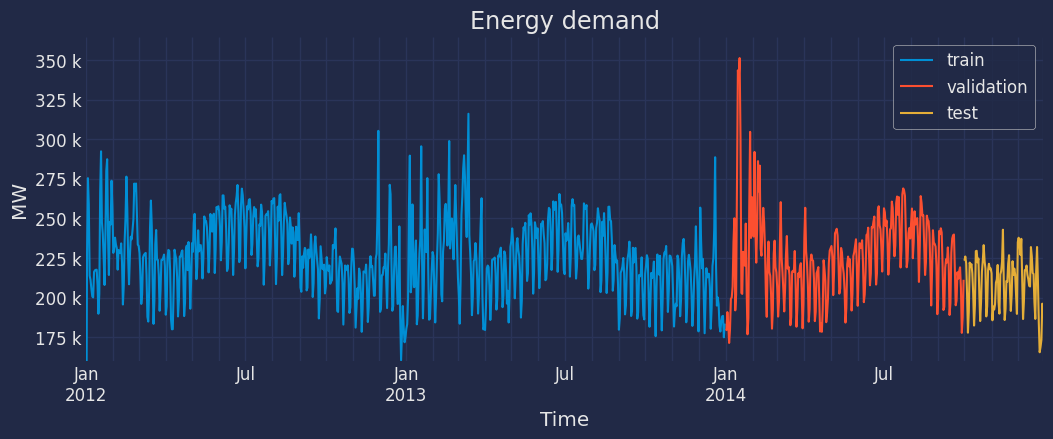

In [7]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend();

In [130]:
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from sklearn.preprocessing import StandardScaler

# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

forecaster.fit(series=data_train)

In [131]:
forecaster.transformer_series

StandardScaler()

In [132]:
forecaster.transformer_series_

{'Demand': StandardScaler(),
 'Temperature': StandardScaler(),
 'Holiday': StandardScaler()}

In [133]:
forecaster.fit(series=data_train[['Demand', 'Temperature']])

In [134]:
forecaster.transformer_series

StandardScaler()

In [135]:
forecaster.transformer_series_

{'Demand': StandardScaler(), 'Temperature': StandardScaler()}

In [105]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor = LGBMRegressor(random_state=123),
                 level     = 'Demand',
                 lags      = 6,
                 steps     = 7
             )

forecaster

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for series: None 
Transformer for exog: None 
Window size: 6 
Multivariate series (names): None 
Maximum steps predicted: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-11-04 11:57:17 
Last fit date: None 
Skforecast version: 0.6.0 
Python version: 3.9.1

In [106]:
forecaster.lags

array([1, 2, 3, 4, 5, 6])

In [107]:
forecaster.lags_

array([1, 2, 3, 4, 5, 6])

In [108]:
forecaster.create_train_X_y(series=data_train)[0]

,Demand_lag_1,Demand_lag_2,Demand_lag_3,Demand_lag_4,Demand_lag_5,Demand_lag_6,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3,Temperature_lag_4,Temperature_lag_5,Temperature_lag_6,Holiday_lag_1,Holiday_lag_2,Holiday_lag_3,Holiday_lag_4,Holiday_lag_5,Holiday_lag_6
Time,,,,,,,,,,,,,,,,,,
2012-01-13,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,82531.745918,17.812500,18.191667,24.567708,31.751042,26.578125,21.047727,0.0,0.0,0.0,1.0,1.0,1.0
2012-01-14,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,19.510417,17.812500,18.191667,24.567708,31.751042,26.578125,0.0,0.0,0.0,0.0,1.0,1.0
2012-01-15,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,24.098958,19.510417,17.812500,18.191667,24.567708,31.751042,0.0,0.0,0.0,0.0,0.0,1.0
2012-01-16,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,20.223958,24.098958,19.510417,17.812500,18.191667,24.567708,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-17,216201.836844,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,19.161458,20.223958,24.098958,19.510417,17.812500,18.191667,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,288719.964068,243686.647524,225126.095924,219991.933602,193253.553056,180247.188308,29.289583,21.720833,16.989583,16.925000,17.031250,16.237500,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-28,220660.723898,288719.964068,243686.647524,225126.095924,219991.933602,193253.553056,18.445833,29.289583,21.720833,16.989583,16.925000,17.031250,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-29,194898.909304,220660.723898,288719.964068,243686.647524,225126.095924,219991.933602,19.337500,18.445833,29.289583,21.720833,16.989583,16.925000,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
forecaster.lags

array([1, 2, 3, 4, 5, 6])

In [110]:
forecaster.lags_

{'Demand': array([1, 2, 3, 4, 5, 6]),
 'Temperature': array([1, 2, 3, 4, 5, 6]),
 'Holiday': array([1, 2, 3, 4, 5, 6])}

In [111]:
forecaster.create_train_X_y(series=data_train[['Demand', 'Temperature']])[0]

,Demand_lag_1,Demand_lag_2,Demand_lag_3,Demand_lag_4,Demand_lag_5,Demand_lag_6,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3,Temperature_lag_4,Temperature_lag_5,Temperature_lag_6
Time,,,,,,,,,,,,
2012-01-13,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,82531.745918,17.812500,18.191667,24.567708,31.751042,26.578125,21.047727
2012-01-14,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,19.510417,17.812500,18.191667,24.567708,31.751042,26.578125
2012-01-15,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,24.098958,19.510417,17.812500,18.191667,24.567708,31.751042
2012-01-16,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,20.223958,24.098958,19.510417,17.812500,18.191667,24.567708
2012-01-17,216201.836844,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,19.161458,20.223958,24.098958,19.510417,17.812500,18.191667
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,288719.964068,243686.647524,225126.095924,219991.933602,193253.553056,180247.188308,29.289583,21.720833,16.989583,16.925000,17.031250,16.237500
2013-12-28,220660.723898,288719.964068,243686.647524,225126.095924,219991.933602,193253.553056,18.445833,29.289583,21.720833,16.989583,16.925000,17.031250
2013-12-29,194898.909304,220660.723898,288719.964068,243686.647524,225126.095924,219991.933602,19.337500,18.445833,29.289583,21.720833,16.989583,16.925000


In [112]:
forecaster.lags

array([1, 2, 3, 4, 5, 6])

In [114]:
forecaster.lags_

{'Demand': array([1, 2, 3, 4, 5, 6]), 'Temperature': array([1, 2, 3, 4, 5, 6])}

In [115]:
X_train, y_train = forecaster.create_train_X_y(series=data_train[['Demand', 'Temperature']])
forecaster.filter_train_X_y_for_step(step=7, X_train=X_train, y_train=y_train)[1]

Time
2012-01-13    217586.174464
2012-01-14    207841.939388
2012-01-15    189761.960344
2012-01-16    202284.682756
2012-01-17    266364.444274
                  ...      
2013-12-27    184792.154270
2013-12-28    188069.028852
2013-12-29    188395.222982
2013-12-30    174850.711420
2013-12-31    183444.108000
Freq: D, Name: Demand_step_7, Length: 719, dtype: float64

In [116]:
forecaster.fit(series=data_train[['Demand', 'Temperature']])

In [117]:
# Predict
# ==============================================================================
steps = 5
predictions = forecaster.predict(steps=steps)
predictions

,Demand
2014-01-01,190422.511002
2014-01-02,188276.312492
2014-01-03,209370.195200
2014-01-04,227962.434209
2014-01-05,231965.325126


In [118]:
steps = [5]
predictions = forecaster.predict(steps=steps)
predictions

,Demand
2014-01-05,231965.325126


In [119]:
steps = [1, 5]
predictions = forecaster.predict(steps=steps)
predictions

,Demand
2014-01-01,190422.511002
2014-01-05,231965.325126


In [120]:
predictions = forecaster.predict(steps=None)
predictions

,Demand
2014-01-01,190422.511002
2014-01-02,188276.312492
2014-01-03,209370.195200
2014-01-04,227962.434209
2014-01-05,231965.325126
2014-01-06,226973.953236
2014-01-07,243830.114027


In [121]:
forecaster.set_params({'n_estimators': 500})

In [123]:
forecaster

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor(n_estimators=500, random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for series: None 
Transformer for exog: None 
Window size: 6 
Multivariate series (names): ['Demand', 'Temperature'] 
Maximum steps predicted: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2013-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 

In [126]:
forecaster.set_lags({'Demand': 4})
forecaster.lags

{'Demand': array([1, 2, 3, 4])}

In [127]:
forecaster.lags_

{'Demand': array([1, 2, 3, 4])}

In [129]:
forecaster.regressors_[1].fea

LGBMRegressor(n_estimators=500, random_state=123)

In [128]:
forecaster.get_feature_importance(1)

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiVariate\ForecasterAutoregMultiVariate.py:1012: UserWarning: Impossible to access feature importance for regressor of type <class 'lightgbm.sklearn.LGBMRegressor'>. This method is only valid when the regressor stores internally the feature importance in the attribute `feature_importances_` or `coef_`.
  except:


In [58]:
forecaster.get_feature_importance(7)

,feature,importance
0,Demand_lag_1,212
1,Demand_lag_2,158
2,Demand_lag_3,170
3,Demand_lag_4,153
4,Demand_lag_5,179
5,Demand_lag_6,178
6,Demand_lag_7,169
7,Temperature_lag_1,285
8,Temperature_lag_2,173
9,Temperature_lag_3,212


In [5]:
pd.RangeIndex(start=50, stop=55, step=1)[[1, 4]]

Int64Index([51, 54], dtype='int64')

In [5]:
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [32]:
forecaster = ForecasterAutoregDirect(LinearRegression(), lags=3, steps=1)
results = forecaster._create_lags(y=np.arange(10))
results

(array([[2., 1., 0.],
        [3., 2., 1.],
        [4., 3., 2.],
        [5., 4., 3.],
        [6., 5., 4.],
        [7., 6., 5.],
        [8., 7., 6.]]),
 array([[3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]]))

In [33]:
series = pd.DataFrame(
             data = np.array([[0.12362923, 0.51328688],
                              [0.65138268, 0.11599708],
                              [0.58142898, 0.72350895],
                              [0.72969992, 0.10305721],
                              [0.97790567, 0.20581485],
                              [0.56924731, 0.41262027],
                              [0.85369084, 0.82107767],
                              [0.75425194, 0.0107816 ],
                              [0.08167939, 0.94951918],
                              [0.00249297, 0.55583355]]),
             columns= ['series_1', 'series_2'],
             index = pd.DatetimeIndex(
                         ['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
                          '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
                          '2022-01-12', '2022-01-13'],
                         dtype='datetime64[ns]', freq='D'
                     ),
         )

In [43]:
forecaster = ForecasterAutoregMultiVariate(
                     level       = 'series_1',
                     lags        = 3,
                     steps       = 3,    
                     regressor   = LinearRegression(),
                     weight_func = None
                 )

forecaster.create_train_X_y(series=series)[0].columns

Index(['series_1_lag_1', 'series_1_lag_2', 'series_1_lag_3', 'series_2_lag_1',
       'series_2_lag_2', 'series_2_lag_3'],
      dtype='object')

In [42]:
forecaster.create_train_X_y(series=series)[1]     

,series_1_step_1,series_1_step_2,series_1_step_3
2022-01-09,0.729700,0.977906,0.569247
2022-01-10,0.977906,0.569247,0.853691
2022-01-11,0.569247,0.853691,0.754252
2022-01-12,0.853691,0.754252,0.081679
2022-01-13,0.754252,0.081679,0.002493


## Predict tests

In [6]:
import re
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [7]:
series = pd.DataFrame({'l1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                )
                            ), 
                       'l2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                )
                            )
                      }
         )
    
exog = pd.DataFrame({'exog_1': pd.Series(np.array(
                                [0.51312815, 0.66662455, 0.10590849, 0.13089495, 0.32198061,
                                 0.66156434, 0.84650623, 0.55325734, 0.85445249, 0.38483781,
                                 0.3167879 , 0.35426468, 0.17108183, 0.82911263, 0.33867085,
                                 0.55237008, 0.57855147, 0.52153306, 0.00268806, 0.98834542,
                                 0.90534158, 0.20763586, 0.29248941, 0.52001015, 0.90191137,
                                 0.98363088, 0.25754206, 0.56435904, 0.80696868, 0.39437005,
                                 0.73107304, 0.16106901, 0.60069857, 0.86586446, 0.98352161,
                                 0.07936579, 0.42834727, 0.20454286, 0.45063649, 0.54776357,
                                 0.09332671, 0.29686078, 0.92758424, 0.56900373, 0.457412  ,
                                 0.75352599, 0.74186215, 0.04857903, 0.7086974 , 0.83924335]
                                )
                              ),
                     'exog_2': ['a']*25 + ['b']*25}
       )

In [28]:
forecaster = ForecasterAutoregMultiVariate(LinearRegression(), level='l2',
                                               lags={'l1': 5, 'l2': [1, 7]}, steps=3)
forecaster.fit(series=series)
results = forecaster.predict(steps=None)
results['l2'].values

array([0.58053278, 0.43052971, 0.60582844])

In [29]:
forecaster.last_window

,l1,l2
43,0.414826,0.762548
44,0.866309,0.593177
45,0.250455,0.691702
46,0.483034,0.151127
47,0.985560,0.398876
48,0.519485,0.240856
49,0.612895,0.343456


In [27]:
forecaster = ForecasterAutoregMultiVariate(LinearRegression(), level='l1',
                                               lags=3, steps=3)
forecaster.fit(series=series.iloc[:40,], exog=exog.iloc[:40, 0])
results = forecaster.predict(steps=None, exog=exog.iloc[40:43, 0])
results.values

array([[0.57243323],
       [0.56121924],
       [0.38879785]])

In [61]:
m = ColumnTransformer(
        [('scale', StandardScaler(), ['l1']),
         ('mixmax', MinMaxScaler(), ['l2'])],
        remainder = 'passthrough',
        verbose_feature_names_out = False
    )
series_transformed = m.fit_transform(series)
series_transformed = pd.DataFrame(
                   data    = series_transformed,
                   index   = pd.RangeIndex(start=0, stop=50, step=1),
                   columns = ['l1', 'l2']
               )

forecaster = ForecasterAutoregMultiVariate(LinearRegression(), level='l2',
                                           lags=5, steps=5)
forecaster.fit(series=series_transformed)
results = forecaster.predict(steps=None)

# results['l2'] = list(range(5))
m.transformers_[1][1].inverse_transform(results)

array([[0.65049981],
       [0.57548048],
       [0.64278726],
       [0.54421867],
       [0.7851753 ]])

In [57]:
m.transformers_

[('scale', StandardScaler(), ['l1']), ('mixmax', MinMaxScaler(), ['l2'])]

In [59]:
forecaster = ForecasterAutoregMultiVariate(
                     regressor          = LinearRegression(),
                     level              = 'l2',
                     lags               = 5,
                     steps              = 5,
                     transformer_series = {'l1': StandardScaler(), 'l2': MinMaxScaler()}
                 )
forecaster.fit(series=series)
results = forecaster.predict()
results

,l2
50,0.650500
51,0.575480
52,0.642787
53,0.544219
54,0.785175


In [44]:
forecaster = ForecasterAutoregMultiVariate(
                     regressor          = LinearRegression(),
                     level              = 'l1',
                     lags               = 5,
                     steps              = 5,
                     transformer_series = StandardScaler(),
                 )
forecaster.fit(series=series)
results = forecaster.predict()
expected = pd.DataFrame(
                data    = np.array([0.60056539, 0.42924504, 0.34173573, 0.44231236, 0.40133213]),
                index   = pd.RangeIndex(start=50, stop=55, step=1),
                columns = ['l1']
            )

pd.testing.assert_frame_equal(results, expected)

In [45]:
transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['exog_1']),
                             ('onehot', OneHotEncoder(), ['exog_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                       )
forecaster = ForecasterAutoregMultiVariate(
                    regressor          = LinearRegression(),
                    level              = 'l1',
                    lags               = 5,
                    steps              = 5,
                    transformer_series = StandardScaler(),
                    transformer_exog   = transformer_exog
                )
forecaster.fit(series=series, exog=exog)
results = forecaster.predict(steps=[1, 2, 3, 4, 5], exog=exog)
results

,l1
50,0.610432
51,0.466581
52,0.549945
53,0.525612
54,0.465965


In [47]:
forecaster.transformer_series_

{'l1': StandardScaler(), 'l2': StandardScaler()}

In [48]:
m = StandardScaler()
series_transformed = m.fit_transform(series)
series_transformed = pd.DataFrame(
                   data    = series_transformed,
                   index   = pd.RangeIndex(start=0, stop=50, step=1),
                   columns = ['l1', 'l2']
               )

exog_tra =  ColumnTransformer(
                [('scale', StandardScaler(), ['exog_1']),
                    ('onehot', OneHotEncoder(), ['exog_2'])],
                remainder = 'passthrough',
                verbose_feature_names_out = False
            )
exog_transformed = exog_tra.fit_transform(exog)
exog_transformed = pd.DataFrame(
                   data    = exog_transformed,
                   index   = pd.RangeIndex(start=0, stop=50, step=1),
                   columns = ['exog_1', 'exog_2_a', 'exog_2_b']
               )

forecaster = ForecasterAutoregMultiVariate(LinearRegression(), level='l1',
                                           lags=5, steps=5)
forecaster.fit(series=series_transformed, exog=exog_transformed)
results = forecaster.predict(steps=None, exog=exog_transformed)

results['l2'] = list(range(5))
m.inverse_transform(results)

array([[0.61043227, 0.50099989],
       [0.46658137, 0.75864045],
       [0.54994519, 1.01628101],
       [0.52561227, 1.27392157],
       [0.46596527, 1.53156213]])

In [4]:
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

series = pd.DataFrame({'l1': pd.Series(np.arange(10)), 
                        'l2': pd.Series(np.arange(10))
                        })
forecaster = ForecasterAutoregMultiVariate(
                    regressor = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
                    level     = 'l1',
                    lags      = 3,
                    steps     = 1
                )
forecaster.fit(series=series)
# forecaster.fit(series=series, exog=pd.Series(np.arange(10), name='exog'))
forecaster.regressors_[0][-1].feature_importances_

NameError: name 'ForecasterAutoregMultiVariate' is not defined

In [79]:
import re
import pytest
import numpy as np
import pandas as pd
from pytest import approx
import sys
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import NotFittedError
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

In [6]:
series = pd.DataFrame({'l1': pd.Series(np.array(
                                 [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                  0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                  0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                  0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                  0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                  0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                  0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                  0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                  0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                  0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                       )
                             ), 
                       'l2': pd.Series(np.array(
                                 [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                  0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                  0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                  0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                  0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                  0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                  0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                  0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                  0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                  0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                       )
                             )
         })

In [88]:
    forecaster = ForecasterAutoregMultiVariate(
                     regressor = Ridge(random_state=123),
                     level     = 'l1',
                     lags      = 2,
                     steps     = 3
                 )

    steps = 3
    n_validation = 12
    lags_grid = [2, 4]
    param_distributions = {'alpha':np.logspace(-5, 3, 10)}
    n_iter = 3

    results = random_search_forecaster_multiseries(
                    forecaster          = forecaster,
                    series              = series,
                    param_distributions = param_distributions,
                    steps               = steps,
                    metric              = 'mean_absolute_error',
                    initial_train_size  = len(series) - n_validation,
                    fixed_train_size    = False,
                    levels              = None,
                    levels_weights      = None,
                    exog                = None,
                    lags_grid           = lags_grid,
                    refit               = False,
                    n_iter              = n_iter,
                    return_best         = False,
                    verbose             = False
              )

c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection_multiseries\model_selection_multiseries.py:864: UserWarning: `levels_weights` is deprecated since version 0.6.0, and will be removed in version 0.7.0. Use `series_weights` when creating the forecaster instead.
  warnings.warn(


6 models compared for 1 level(s). Number of iterations: 6.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 41.12it/s]


In [89]:
results

,levels,lags,params,mean_absolute_error,alpha
1,[l1],"[1, 2]",{'alpha': 1e-05},0.201071,0.000010
0,[l1],"[1, 2]",{'alpha': 0.03593813663804626},0.201357,0.035938
2,[l1],"[1, 2]",{'alpha': 16.681005372000556},0.209912,16.681005
5,[l1],"[1, 2, 3, 4]",{'alpha': 16.681005372000556},0.211212,16.681005
3,[l1],"[1, 2, 3, 4]",{'alpha': 0.03593813663804626},0.226403,0.035938
4,[l1],"[1, 2, 3, 4]",{'alpha': 1e-05},0.226454,0.000010


In [92]:
results.alpha.values

array([1.00000000e-05, 3.59381366e-02, 1.66810054e+01, 1.66810054e+01,
       3.59381366e-02, 1.00000000e-05])

In [86]:
results.mean_squared_error.values

AttributeError: 'DataFrame' object has no attribute 'mean_squared_error'

In [55]:
results.alpha.values

array([0.01, 0.1 , 1.  , 1.  , 0.1 , 0.01, 1.  , 0.1 , 0.01])

In [56]:
results.index

Int64Index([0, 1, 2, 5, 4, 3, 8, 7, 6], dtype='int64')

In [93]:
    forecaster = ForecasterAutoregMultiVariate(
                     regressor = Ridge(random_state=123),
                     level     = 'l1',
                     lags      = 2,
                     steps     = 3
                 )

    steps = 3
    n_validation = 12
    lags_grid = [2, 4]
    param_distributions = {'alpha':np.logspace(-5, 3, 10)}
    n_iter = 3

    results = random_search_forecaster_multiseries(
                    forecaster          = forecaster,
                    series              = series,
                    param_distributions = param_distributions,
                    steps               = steps,
                    metric              = 'mean_absolute_error',
                    initial_train_size  = len(series) - n_validation,
                    fixed_train_size    = False,
                    levels              = None,
                    levels_weights      = None,
                    exog                = None,
                    lags_grid           = lags_grid,
                    refit               = False,
                    n_iter              = n_iter,
                    return_best         = False,
                    verbose             = True
              )
    
    expected_results = pd.DataFrame({
            'levels': [['l1'], ['l1'], ['l1'], ['l1'], ['l1'], ['l1']],
            'lags'  : [[1, 2], [1, 2], [1, 2], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]],
            'params': [{'alpha': 1e-05}, {'alpha': 0.03593813663804626}, {'alpha': 16.681005372000556},
                       {'alpha': 16.681005372000556}, {'alpha': 0.03593813663804626}, {'alpha': 1e-05}],
            'mean_absolute_error': np.array([0.20107097, 0.20135665, 0.20991177, 0.21121154, 0.22640335, 0.22645387]),                                                               
            'alpha' : np.array([1.00000000e-05, 3.59381366e-02, 1.66810054e+01, 1.66810054e+01, 3.59381366e-02, 1.00000000e-05])
                                     },
            index=[1, 0, 2, 5, 3, 4]
                                   )

    pd.testing.assert_frame_equal(results, expected_results)

c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection_multiseries\model_selection_multiseries.py:864: UserWarning: `levels_weights` is deprecated since version 0.6.0, and will be removed in version 0.7.0. Use `series_weights` when creating the forecaster instead.
  warnings.warn(


6 models compared for 1 level(s). Number of iterations: 6.


loop lags_grid:   0%|                                               | 0/2 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 38
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   0 -- 37  (n=38)
    Validation: 38 -- 40  (n=3)
Data partition in fold: 1
    Training:   0 -- 37  (n=38)
    Validation: 41 -- 43  (n=3)
Data partition in fold: 2
    Training:   0 -- 37  (n=38)
    Validation: 44 -- 46  (n=3)
Data partition in fold: 3
    Training:   0 -- 37  (n=38)
    Validation: 47 -- 49  (n=3)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 38
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   0 -- 37  (n=38)
    Validation: 38 -- 40  (n=3)
Data partition in fold: 1
    Training:   0 -- 37  (n=38)
    Validation: 41 -- 43  (n=3)
Data 

loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 39.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 38
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   0 -- 37  (n=38)
    Validation: 38 -- 40  (n=3)
Data partition in fold: 1
    Training:   0 -- 37  (n=38)
    Validation: 41 -- 43  (n=3)
Data partition in fold: 2
    Training:   0 -- 37  (n=38)
    Validation: 44 -- 46  (n=3)
Data partition in fold: 3
    Training:   0 -- 37  (n=38)
    Validation: 47 -- 49  (n=3)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 38
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   0 -- 37  (n=38)
    Validation: 38 -- 40  (n=3)
Data partition in fold: 1
    Training:   0 -- 37  (n=38)
    Validation: 41 -- 43  (n=3)
Data 

In [82]:
results

,levels,lags,params,mean_absolute_error,alpha
0,[l1],"[1, 2]",{'alpha': 0.01},0.201152,0.01
1,[l1],"[1, 2]",{'alpha': 0.1},0.201830,0.10
2,[l1],"[1, 2]",{'alpha': 1},0.205669,1.00
5,[l1],"[1, 2, 3, 4]",{'alpha': 1},0.222243,1.00
4,[l1],"[1, 2, 3, 4]",{'alpha': 0.1},0.226250,0.10
3,[l1],"[1, 2, 3, 4]",{'alpha': 0.01},0.226443,0.01
